# Imports

In [1]:
import cv2
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from PIL import Image

# Directories

In [2]:
main_kkanji_dir = "/home/beav3r/Bachelor_work/Bachelor_work/data/kkanji/kkanji2"
generative_kkanji_dir = "/mnt/d/Bachelor_work/data_for_model/kkanji2_with_gen"
kkanji_for_GAN_dir = "/mnt/d/Bachelor_work/data_for_model/kkanji_for_GAN"
kkanji_for_VAE_dir = "/mnt/d/Bachelor_work/data_for_model/kkanji_for_VAE"
kkanji_for_aug2_dir = "/mnt/d/Bachelor_work/data_for_model/kkanji_for_aug2"
kkanji_aug_only_dir = "/mnt/d/Bachelor_work/data_for_model/kkanji_balanced_aug_only"

# Global variables

In [3]:
int_inf = 9223372036854775807

num_classes_GAN = 0
for i in os.listdir(kkanji_for_GAN_dir):
    num_classes_GAN += 1
num_classes_GAN

num_classes_VAE = 0

# Helping functions

In [4]:
# Define the loss function for VAE
def loss_function_VAE(reconstructed_img, original_img, mu, logvar):
    # Reconstruction loss (using MSE or BCE)
    recon_loss = F.mse_loss(reconstructed_img, original_img, reduction='sum')

    # KL Divergence: regularizing the latent space
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss: reconstruction + KL divergence
    return recon_loss + kl_loss

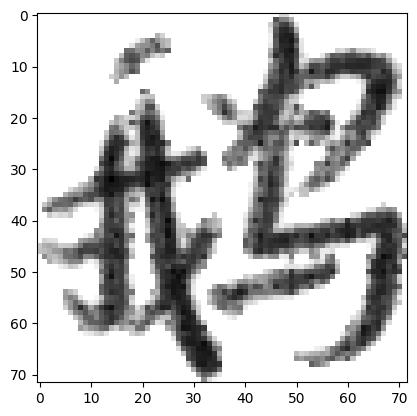

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..1.0].


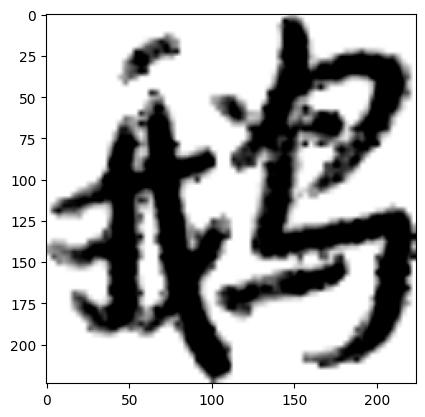

In [5]:
# Image preprocessing for resnet 18

# Preprocessing: Resize to 224x224 and stack the grayscale image into 3 channels
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),     # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),             # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
])

# Load and preprocess image
image = Image.open('/home/beav3r/Bachelor_work/Bachelor_work/data/CASIA Online and Offline Chinese Handwriting Databases/My_processed_Gnt1.0Train/鹅/0.png')  # Open image 


# Save original image
image.save('/mnt/d/Bachelor_work/data_for_model/test.png')

# Show original image
plt.imshow(image, cmap='gray')  # Show image
plt.show()

image_tensor_without_batch = preprocess(image)  # Preprocess image

# Add batch dimension
image_tensor = image_tensor_without_batch.unsqueeze(0)  # Add batch size

# Show image
plt.imshow(image_tensor[0].permute(1, 2, 0).numpy())  # Show image



In [6]:
kkanji_images_classes_by_amount = defaultdict(list)
kkanji_images_classes_by_amount['1-14'] = []
kkanji_images_classes_by_amount['15-29'] = []
kkanji_images_classes_by_amount['30-99'] = []
kkanji_images_classes_by_amount['100-299'] = []
kkanji_images_classes_by_amount['300+'] = []
kkanji_images_accumulator = defaultdict(int)
kkanji_images_accumulator['1-14'] = 0
kkanji_images_accumulator['15-29'] = 0
kkanji_images_accumulator['30-99'] = 0
kkanji_images_accumulator['100-299'] = 0
kkanji_images_accumulator['300+'] = 0

# Function to classify the value into the appropriate category
def classify_value(value):
    if 1 <= value <= 14:
        return '1-14'
    elif 15 <= value <= 29:
        return '15-29'
    elif 30 <= value <= 99:
        return '30-99'
    elif 100 <= value <= 299:
        return '100-299'
    else:
        return '300+'

# Read and process the file
with open('/home/beav3r/Bachelor_work/Bachelor_work/kkanji_classes_distribution_sorted.txt', 'r') as file:
    for line in file:
        # Split the line into Unicode character and value
        unicode_char, value_str = line.strip().split()
        value = int(value_str)
        
        # Classify the value and add to the appropriate category
        category = classify_value(value)
        kkanji_images_classes_by_amount[category].append(unicode_char)

        # Accumulate the value
        kkanji_images_accumulator[category] += value

# Print the dictionary to verify the result
for category, unicode_chars in kkanji_images_classes_by_amount.items():
    print(f"{category}: {unicode_chars} ({len(unicode_chars)}) AVG: {kkanji_images_accumulator[category] / len(unicode_chars)}")

1-14: ['U+9808', 'U+6182', 'U+7169', 'U+7981', 'U+770B', 'U+5E97', 'U+98FD', 'U+8B02', 'U+56FA', 'U+5805', 'U+52FA', 'U+72D0', 'U+79AE', 'U+99C4', 'U+9591', 'U+6176', 'U+7C9F', 'U+7B39', 'U+9298', 'U+6271', 'U+57F7', 'U+65E7', 'U+697C', 'U+5DF2', 'U+8AFA', 'U+8A2D', 'U+5BE6', 'U+671F', 'U+6804', 'U+76DC', 'U+5951', 'U+8B49', 'U+5B78', 'U+6939', 'U+67AF', 'U+8CAF', 'U+53F7', 'U+536F', 'U+804A', 'U+86FE', 'U+99B3', 'U+7B0B', 'U+689D', 'U+5036', 'U+839E', 'U+5E0C', 'U+5B09', 'U+83F4', 'U+99C8', 'U+7BA1', 'U+53F2', 'U+5302', 'U+9D89', 'U+7384', 'U+96CC', 'U+6D32', 'U+9D2C', 'U+9685', 'U+52DE', 'U+91C8', 'U+5504', 'U+9C39', 'U+8F9E', 'U+7078', 'U+7ADF', 'U+9451', 'U+7434', 'U+6578', 'U+5C31', 'U+9B54', 'U+4FEF', 'U+82DE', 'U+6C60', 'U+523A', 'U+8429', 'U+99D5', 'U+6D74', 'U+6B6F', 'U+5BDD', 'U+5962', 'U+9818', 'U+7D9A', 'U+854E', 'U+6AFB', 'U+5215', 'U+8A8D', 'U+9B22', 'U+901F', 'U+96E2', 'U+6D78', 'U+4EF6', 'U+59D3', 'U+9244', 'U+602A', 'U+6F09', 'U+6276', 'U+8A82', 'U+548E', 'U+6190', 'U+

In [6]:
# Define the augmentation pipeline

augmentation_pipeline = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(64, scale=(0.95, 1.05)),
    transforms.RandomAffine(degrees=0, shear=0.05),
    # transforms.ToTensor(),  # Convert PIL image to tensor
    # transforms.Lambda(lambda img: img + torch.randn_like(img) * 0.01),  # Add random noise
    # transforms.ToPILImage()  # Convert tensor back to PIL image
    
])

In [37]:
# For each directory in group '1-14' enable image augmentation to reach 15 images

for unicode_char in kkanji_images_classes_by_amount['1-14']:
    # Define the directory
    char_dir = os.path.join(main_kkanji_dir, unicode_char)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Check if there are less than 15 images
    if len(files) < 15:
        # Apply augmentation pipeline
        for i in range(15 - len(files)):
            # Load the random image
            rand_number = np.random.randint(0, len(files))
            image = Image.open(os.path.join(char_dir, files[rand_number]))

            augmented_image = augmentation_pipeline(image)

            save_dir = os.path.join(generative_kkanji_dir, unicode_char)
            os.makedirs(save_dir, exist_ok=True)
            
            # Save the augmented image
            augmented_image.save(os.path.join(save_dir, f"gen_aug1_{i}.png"))

# Kanji for training GAN

In [45]:
# copy all ''1-14' and '15-29' images from kkanji2_with_gen directory to the kkanji_for_GAN directory 

for unicode_char in kkanji_images_classes_by_amount['1-14'] + kkanji_images_classes_by_amount['15-29']:
    # Define the directory
    char_dir = os.path.join(generative_kkanji_dir, unicode_char)

    # Create the directory in kkanji_for_GAN
    os.makedirs(os.path.join(kkanji_for_GAN_dir, unicode_char), exist_ok=True)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Copy all files to the kkanji_for_GAN directory
    for file in files:
        os.system(f"cp {os.path.join(char_dir, file)} {os.path.join(kkanji_for_GAN_dir, unicode_char)}")

# Big CGAN

In [12]:
# Define the Generator for Conditional GAN with Embeddings
class Generator_big(nn.Module):
    def __init__(self, latent_dim, img_shape, num_classes, embedding_dim=100):
        super(Generator_big, self).__init__()
        self.img_shape = img_shape
        self.embedding_dim = embedding_dim
        self.label_emb = nn.Embedding(num_classes, embedding_dim)  # Embedding layer

        self.model = nn.Sequential(
            nn.Linear(latent_dim + embedding_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()  # Output normalized to (-1, 1)
        )

    def forward(self, z, labels):
        # Embedding class labels
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((z, label_embedding), -1)  # Concatenate noise and label embeddings
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)  # Reshape to image format
        return img

# Define the Discriminator for Conditional GAN with Embeddings
class Discriminator_big(nn.Module):
    def __init__(self, img_shape, num_classes, embedding_dim=100):
        super(Discriminator_big, self).__init__()
        self.embedding_dim = embedding_dim
        self.label_emb = nn.Embedding(num_classes, embedding_dim)  # Embedding layer

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.model = nn.Sequential(
            nn.Linear(img_flattened_size + embedding_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output as probability
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        label_embedding = self.label_emb(labels)
        d_in = torch.cat((img_flat, label_embedding), -1)  # Concatenate image and label embeddings
        
        # print("D_in: ", d_in.shape, d_in)
        # print("Label embedding: ", label_embedding.shape, label_embedding)
        # print("Img_flat: ", img_flat.shape, img_flat)
        
        validity = self.model(d_in)
        return validity

# Conv CGAN

In [11]:
# Define the Generator with convolutional layers for GAN Conditional GAN with Embeddings
class Generator_conv(nn.Module):
    def __init__(self, latent_dim, embedding_dim, num_classes):
        super(Generator_conv, self).__init__()
        
        # Define the input embedding layer
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        
        # Define the linear layer to map the latent vector to the convolutional layer
        self.linear = nn.Linear(latent_dim + embedding_dim, 128 * 8 * 8)
        
        # Define the convolutional layers
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            # nn.BatchNorm2d(16),
            # nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z, labels):
        # Get the embeddings
        embeddings = self.embedding(labels)
        
        # Concatenate the embeddings with the latent vector
        input = torch.cat((z, embeddings), dim=1)
        
        # Map the input to the convolutional layer
        x = self.linear(input)
        x = x.view(-1, 128, 8, 8)
        
        # Forward pass through the convolutional layers
        x = self.conv(x)
        
        return x
    
# Define the Discriminator with convolutional layers for Conditional GAN with Embeddings
class Discriminator_conv(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(Discriminator_conv, self).__init__()
        
        # Define the input embedding layer
        self.embedding = nn.Embedding(num_classes, embedding_dim)
        
        # Define the convolutional layers
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        
        # Define the linear layer to map the convolutional layer to the output
        self.linear = nn.Linear(256 * 8 * 8 + embedding_dim, 1)

        # Define the sigmoid layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, labels):
        # Forward pass through the convolutional layers
        x = self.conv(x)
        
        # Flatten the output
        x = x.view(-1, 256 * 8 * 8)
        
        # Get the embeddings
        embeddings = self.embedding(labels)
        
        # Concatenate the embeddings with the flattened output
        input = torch.cat((x, embeddings), dim=1)
        
        # Forward pass through the linear layer
        x = self.linear(input)

        # Forward pass through the sigmoid layer
        x = self.sigmoid(x)
        
        return x
    


# Original GAN

In [9]:
# Define the Generator for Conditional GAN with Embeddings
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape, num_classes, embedding_dim=100):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.embedding_dim = embedding_dim
        self.label_emb = nn.Embedding(num_classes, embedding_dim)  # Embedding layer

        self.model = nn.Sequential(
            nn.Linear(latent_dim + embedding_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()  # Output normalized to (-1, 1)
        )

    def forward(self, z, labels):
        # Embedding class labels
        label_embedding = self.label_emb(labels)
        gen_input = torch.cat((z, label_embedding), -1)  # Concatenate noise and label embeddings
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)  # Reshape to image format
        return img

# Define the Discriminator for Conditional GAN with Embeddings
class Discriminator(nn.Module):
    def __init__(self, img_shape, num_classes, embedding_dim=100):
        super(Discriminator, self).__init__()
        self.embedding_dim = embedding_dim
        self.label_emb = nn.Embedding(num_classes, embedding_dim)  # Embedding layer

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.model = nn.Sequential(
            nn.Linear(img_flattened_size + embedding_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output as probability
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        label_embedding = self.label_emb(labels)
        d_in = torch.cat((img_flat, label_embedding), -1)  # Concatenate image and label embeddings
        
        # print("D_in: ", d_in.shape, d_in)
        # print("Label embedding: ", label_embedding.shape, label_embedding)
        # print("Img_flat: ", img_flat.shape, img_flat)
        
        validity = self.model(d_in)
        return validity

# Dataloader CGAN

In [37]:
# Loss function
adversarial_loss = nn.BCELoss()

# Data loader for real images (replace with your dataset)
dataloader_GAN = DataLoader(
    datasets.ImageFolder(
        kkanji_for_GAN_dir,
        transform=transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to (-1, 1)
        ])
    ),
    batch_size=128, shuffle=True, num_workers=4
)

# Original CGAN Training


In [13]:
# Ortiginal training 

epochs = 601  # Number of training epochs

start_epoch = 430

# Initialize the Generator and Discriminator for cGAN
latent_dim = 100  # Dimensionality of the latent noise vector
img_shape = (1, 64, 64)  # Grayscale images (1 channel, 64x64)

# generator = Generator(latent_dim, img_shape, num_classes).cuda()
# discriminator = Discriminator(img_shape, num_classes).cuda()

generator = Generator(latent_dim, img_shape, num_classes_GAN)
discriminator = Discriminator(img_shape, num_classes_GAN)

# Check if the model is already trained
if os.path.exists(f"/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/generator_epoch_{start_epoch}.pth"):
    generator.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/generator_epoch_{start_epoch}.pth"))
    discriminator.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/discriminator_epoch_{start_epoch}.pth"))

    print(f"Loaded generator and discriminator from epoch {start_epoch}")

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

generator.train()
discriminator.train()

# Training loop
for epoch in range(start_epoch, epochs):
    for i, (imgs, labels) in enumerate(dataloader_GAN):
        # Transfer real images and labels to GPU

        # real_imgs = imgs.cuda()
        # labels = labels.cuda()  # Class labels for conditional GAN

        real_imgs = imgs

        # print("Real_imgs: ", real_imgs.shape)

        # Labels for real and fake images (real: 1, fake: 0)

        # real_labels = torch.ones((imgs.size(0), 1)).cuda()
        # fake_labels = torch.zeros((imgs.size(0), 1)).cuda()

        real_labels = torch.ones((imgs.size(0), 1))
        fake_labels = torch.zeros((imgs.size(0), 1))

        # ======================
        # Train Discriminator
        # ======================
        optimizer_D.zero_grad()

        # Sample random noise and generate class labels
        
        # z = torch.randn(imgs.size(0), latent_dim).cuda()

        z = torch.randn(imgs.size(0), latent_dim)

        # Generate fake images based on noise and class labels
        fake_imgs = generator(z, labels)

        # Discriminator loss for real and fake images
        real_loss = adversarial_loss(discriminator(real_imgs, labels), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagation and optimization
        d_loss.backward()
        optimizer_D.step()

        # ======================
        # Train Generator
        # ======================
        for _ in range(5):
            optimizer_G.zero_grad()

            # Generate fake images based on noise and class labels
            z = torch.randn(imgs.size(0), latent_dim) 
            fake_imgs = generator(z, labels)

            # Try to fool the discriminator with generated images
            g_loss = adversarial_loss(discriminator(fake_imgs, labels), real_labels)

            # Backpropagation and optimization
            g_loss.backward()
            optimizer_G.step()

        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader_GAN)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Save generated images at regular intervals
        if i % 300 == 0:
            save_image(fake_imgs.data[:25], f"/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/{epoch}_{i}.png", nrow=5, normalize=True)
        
    # Save the model checkpoints
    if epoch % 10 == 0 and epoch != start_epoch:
        torch.save(generator.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/discriminator_epoch_{epoch}.pth")

        # Save last epoch number
        with open("/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/last_epoch.txt", "w") as file:
            file.write(str(epoch))

/tmp/ipykernel_367754/4046080017.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/GAN_train_ge

Loaded generator and discriminator from epoch 430


NameError: name 'dataloader_GAN' is not defined

# Conv CGAN Training

In [50]:
# Conv GAN training

epochs = 1001  # Number of training epochs
start_epoch = 50

# Initialize the Generator and Discriminator for cGAN
latent_dim = 100  # Dimensionality of the latent noise vector
embedding_dim = 100  # Dimensionality of the class embedding
img_shape = (1, 64, 64)  # Grayscale images (1 channel, 64x64)

# generator = Generator_conv(latent_dim, embedding_dim, num_classes).cuda()
# discriminator = Discriminator_conv(embedding_dim, num_classes).cuda()

generator = Generator_conv(latent_dim, embedding_dim, num_classes_GAN)
discriminator = Discriminator_conv(embedding_dim, num_classes_GAN)

# Check if the model is already trained

if os.path.exists(f"/mnt/d/Bachelor_work/data_for_model/conv_GAN_train_generated/generator_conv_epoch_{start_epoch}.pth"):
    generator.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/conv_GAN_train_generated/generator_conv_epoch_{start_epoch}.pth"))
    discriminator.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/conv_GAN_train_generated/discriminator_conv_epoch_{start_epoch}.pth"))

    print(f"Loaded generator and discriminator from epoch {start_epoch}")

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

generator.train()
discriminator.train()

# Training loop
for epoch in range(start_epoch, epochs):
    for i, (imgs, labels) in enumerate(dataloader_GAN):
        # Transfer real images and labels to GPU

        # real_imgs = imgs.cuda()
        # labels = labels.cuda()  # Class labels for conditional GAN

        real_imgs = imgs

        # print("Real_imgs: ", real_imgs.shape)

        # Labels for real and fake images (real: 1, fake: 0)

        # real_labels = torch.ones((imgs.size(0), 1)).cuda()
        # fake_labels = torch.zeros((imgs.size(0), 1)).cuda()

        real_labels = torch.ones((imgs.size(0), 1))
        fake_labels = torch.zeros((imgs.size(0), 1))

        # ======================
        # Train Discriminator
        # ======================
        optimizer_D.zero_grad()

        # Sample random noise and generate class labels
        
        # z = torch.randn(imgs.size(0), latent_dim).cuda()

        z = torch.randn(imgs.size(0), latent_dim)

        # Generate fake images based on noise and class labels
        fake_imgs = generator(z, labels)

        # Discriminator loss for real and fake images
        real_loss = adversarial_loss(discriminator(real_imgs, labels), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagation and optimization
        d_loss.backward()
        optimizer_D.step()

        # ======================
        # Train Generator
        # ======================
        for _ in range(5):
            optimizer_G.zero_grad()

            # Generate fake images based on noise and class labels
            z = torch.randn(imgs.size(0), latent_dim) 
            fake_imgs = generator(z, labels)

            # Try to fool the discriminator with generated images
            g_loss = adversarial_loss(discriminator(fake_imgs, labels), real_labels)

            # Backpropagation and optimization
            g_loss.backward()
            optimizer_G.step()

        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader_GAN)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Save generated images at regular intervals
        if i % 300 == 0:
            save_image(fake_imgs.data[:25], f"/mnt/d/Bachelor_work/data_for_model/conv_GAN_train_generated/{epoch}_{i}.png", nrow=5, normalize=True)

    # Save the model checkpoints
    if epoch % 5 == 0 and epoch != start_epoch:
        torch.save(generator.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/conv_GAN_train_generated/generator_conv_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/conv_GAN_train_generated/discriminator_conv_epoch_{epoch}.pth")

        # Save last epoch number
        with open("/mnt/d/Bachelor_work/data_for_model/conv_GAN_train_generated/last_epoch.txt", "w") as file:
            file.write(str(epoch))


Loaded generator and discriminator from epoch 50


/tmp/ipykernel_491931/3547472807.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/conv_GAN_tra

[Epoch 50/1001] [Batch 0/372] [D loss: 0.6935524940490723] [G loss: 0.4570632874965668]
[Epoch 50/1001] [Batch 1/372] [D loss: 0.7295355796813965] [G loss: 0.6982858777046204]
[Epoch 50/1001] [Batch 2/372] [D loss: 0.6935823559761047] [G loss: 0.842128574848175]
[Epoch 50/1001] [Batch 3/372] [D loss: 0.7034446001052856] [G loss: 0.7357797622680664]
[Epoch 50/1001] [Batch 4/372] [D loss: 0.6944735646247864] [G loss: 0.6293002367019653]
[Epoch 50/1001] [Batch 5/372] [D loss: 0.6949197053909302] [G loss: 0.6508606672286987]
[Epoch 50/1001] [Batch 6/372] [D loss: 0.6941013932228088] [G loss: 0.714974582195282]
[Epoch 50/1001] [Batch 7/372] [D loss: 0.6934418678283691] [G loss: 0.712973952293396]
[Epoch 50/1001] [Batch 8/372] [D loss: 0.6940141916275024] [G loss: 0.6773192286491394]
[Epoch 50/1001] [Batch 9/372] [D loss: 0.6932759881019592] [G loss: 0.6788725852966309]
[Epoch 50/1001] [Batch 10/372] [D loss: 0.6923555135726929] [G loss: 0.6976972818374634]
[Epoch 50/1001] [Batch 11/372] [D 

KeyboardInterrupt: 

# Big CGAN Training


In [13]:
# Big GAN training

epochs = 1001  # Number of training epochs
start_epoch = 0

# Initialize the Generator and Discriminator for cGAN
latent_dim = 100  # Dimensionality of the latent noise vector
embedding_dim = 100  # Dimensionality of the class embedding
img_shape = (1, 64, 64)  # Grayscale images (1 channel, 64x64)

# generator = Generator_big(latent_dim, img_shape, num_classes).cuda()
# discriminator = Discriminator_big(img_shape, num_classes).cuda()

generator = Generator_big(latent_dim, img_shape, num_classes_GAN)
discriminator = Discriminator_big(img_shape, num_classes_GAN)

# Check if the model is already trained

if os.path.exists(f"/mnt/d/Bachelor_work/data_for_model/big_GAN_train_generated/generator_big_epoch_{start_epoch}.pth"):
    generator.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/big_GAN_train_generated/generator_big_epoch_{start_epoch}.pth"))
    discriminator.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/big_GAN_train_generated/discriminator_big_epoch_{start_epoch}.pth"))

    print(f"Loaded generator and discriminator from epoch {start_epoch}")

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

generator.train()
discriminator.train()

# Training loop
for epoch in range(start_epoch, epochs):
    for i, (imgs, labels) in enumerate(dataloader_GAN):
        # Transfer real images and labels to GPU

        # real_imgs = imgs.cuda()
        # labels = labels.cuda()  # Class labels for conditional GAN

        real_imgs = imgs

        # print("Real_imgs: ", real_imgs.shape)

        # Labels for real and fake images (real: 1, fake: 0)

        # real_labels = torch.ones((imgs.size(0), 1)).cuda()
        # fake_labels = torch.zeros((imgs.size(0), 1)).cuda()

        real_labels = torch.ones((imgs.size(0), 1))
        fake_labels = torch.zeros((imgs.size(0), 1))

        # ======================
        # Train Discriminator
        # ======================
        optimizer_D.zero_grad()

        # Sample random noise and generate class labels
        
        # z = torch.randn(imgs.size(0), latent_dim).cuda()

        z = torch.randn(imgs.size(0), latent_dim)

        # Generate fake images based on noise and class labels
        fake_imgs = generator(z, labels)

        # Discriminator loss for real and fake images
        real_loss = adversarial_loss(discriminator(real_imgs, labels), real_labels)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach(), labels), fake_labels)
        d_loss = (real_loss + fake_loss) / 2

        # Backpropagation and optimization
        d_loss.backward()
        optimizer_D.step()

        # ======================
        # Train Generator
        # ======================
        for _ in range(5):
            optimizer_G.zero_grad()

            # Generate fake images based on noise and class labels
            z = torch.randn(imgs.size(0), latent_dim) 
            fake_imgs = generator(z, labels)

            # Try to fool the discriminator with generated images
            g_loss = adversarial_loss(discriminator(fake_imgs, labels), real_labels)

            # Backpropagation and optimization
            g_loss.backward()
            optimizer_G.step()

        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader_GAN)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Save generated images at regular intervals
        if i % 300 == 0:
            save_image(fake_imgs.data[:25], f"/mnt/d/Bachelor_work/data_for_model/big_GAN_train_generated/{epoch}_{i}.png", nrow=5, normalize=True)

    # Save the model checkpoints
    if epoch % 10 == 0 and epoch != start_epoch:
        torch.save(generator.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/big_GAN_train_generated/generator_big_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/big_GAN_train_generated/discriminator_big_epoch_{epoch}.pth")

        # Save last epoch number
        with open("/mnt/d/Bachelor_work/data_for_model/big_GAN_train_generated/last_epoch.txt", "w") as file:
            file.write(str(epoch))

[Epoch 0/1001] [Batch 0/372] [D loss: 0.6970921754837036] [G loss: 0.6138484477996826
[Epoch 0/1001] [Batch 1/372] [D loss: 0.6480926275253296] [G loss: 0.1846485137939453
[Epoch 0/1001] [Batch 2/372] [D loss: 1.147436261177063] [G loss: 0.21116706728935242
[Epoch 0/1001] [Batch 3/372] [D loss: 1.022820234298706] [G loss: 0.4221837520599365
[Epoch 0/1001] [Batch 4/372] [D loss: 0.785101056098938] [G loss: 0.5847344398498535
[Epoch 0/1001] [Batch 5/372] [D loss: 0.7029513716697693] [G loss: 0.6433526277542114
[Epoch 0/1001] [Batch 6/372] [D loss: 0.6833410263061523] [G loss: 0.6476348638534546
[Epoch 0/1001] [Batch 7/372] [D loss: 0.6830207109451294] [G loss: 0.620567798614502
[Epoch 0/1001] [Batch 8/372] [D loss: 0.7089893221855164] [G loss: 0.4644010365009308
[Epoch 0/1001] [Batch 9/372] [D loss: 0.8894323110580444] [G loss: 0.4340360164642334
[Epoch 0/1001] [Batch 10/372] [D loss: 0.8578359484672546] [G loss: 0.5222459435462952
[Epoch 0/1001] [Batch 11/372] [D loss: 0.763881325721740

KeyboardInterrupt: 

# Test generation with CGANs

In [14]:
latent_dim = 100  # Dimensionality of the latent noise vector
embedding_dim = 100  # Dimensionality of the class embedding
img_shape = (1, 64, 64)  # Grayscale images (1 channel, 64x64)

# Initialize the models (make sure the architecture is the same)
generator = Generator(latent_dim, img_shape, num_classes_GAN)

last_epoch = 420

# Load the saved model parameters
generator.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/GAN_train_generated/generator_epoch_{last_epoch}.pth"))

# Move models to GPU (if available)
# generator.cuda()

# Load the trained generator model
generator.eval()  # Set the model to evaluation mode

# Define the latent noise vector and the class label (e.g., class label U+4C61)
latent_dim = 100  # Dimensionality of the latent noise vector

# class_label = torch.tensor([0]).cuda()

сlass_label = torch.tensor([0])

# Generate random noise vector

# z = torch.randn(1, latent_dim).cuda()

z = torch.randn(1, latent_dim)

# Generate the image for the chosen class
with torch.no_grad():
    generated_img = generator(z, сlass_label)

# Save the generated image
save_image(generated_img[0], f"/mnt/d/Bachelor_work/data_for_model/testing_GAN/{last_epoch}_U+4C61.png", normalize=True)

/tmp/ipykernel_367754/3089575798.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/GAN_train_ge

In [ ]:
# For each directory in group '15-29' use generative adversarial network to reach 30 images

for unicode_char in kkanji_images_classes_by_amount['15-29']:
    # Define the directory
    char_dir = os.path.join(main_kkanji_dir, unicode_char)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Check if there are less than 30 images
    if len(files) < 30:
        # Load the random image
        rand_number = np.random.randint(0, len(files))
        image = Image.open(os.path.join(char_dir, files[rand_number]))
        
        # Apply generative adversarial network to generate the images
        for i in range(30 - len(files)):
            a = 1

In [65]:
test_img_0 = Image.open('/mnt/d/Bachelor_work/data_for_model/kkanji_for_GAN/U+4C61/e6eeb23552e1a21c.png')
test_img_1 = Image.open('/mnt/d/Bachelor_work/data_for_model/kkanji_for_GAN/U+4C61/gen_aug1_0.png')

# Check which img is grayscale
print(test_img_0.mode)
print(test_img_1.mode)

L
L


# Kanji for CVAE

In [ ]:
# copy all ''1-14' and '15-29' and '30-99' images from kkanji2_with_gen directory to the kkanji_for_VAE directory 

for unicode_char in kkanji_images_classes_by_amount['1-14'] + kkanji_images_classes_by_amount['15-29'] + kkanji_images_classes_by_amount['30-99']:
    # Define the directory
    char_dir = os.path.join(generative_kkanji_dir, unicode_char)

    # Create the directory in kkanji_for_GAN
    os.makedirs(os.path.join(kkanji_for_VAE_dir, unicode_char), exist_ok=True)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Copy all files to the kkanji_for_GAN directory
    for file in files:
        os.system(f"cp {os.path.join(char_dir, file)} {os.path.join(kkanji_for_VAE_dir, unicode_char)}")

# original CVAE encoder

In [ ]:
# Encoder for cVAE

class Encoder(nn.Module):
    def __init__(self, img_shape, latent_dim, num_classes, embedding_dim=100):
        super(Encoder, self).__init__()
        self.img_shape = img_shape

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.fc1 = nn.Linear(img_flattened_size + embedding_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Embedding for class labels
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)



    def forward(self, x, labels):
        # Embed labels and concatenate with input images
        label_embeds = self.label_embedding(labels)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, label_embeds], dim=1)  # Concatenate image and label embeddings
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Original CVAE decoder

In [ ]:
# Decoder for cVAE

class Decoder(nn.Module):
    def __init__(self, latent_dim, img_shape, num_classes, embedding_dim=100):
        super(Decoder, self).__init__()

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.fc1 = nn.Linear(latent_dim + embedding_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, img_flattened_size)
        self.img_shape = img_shape

        # Embedding for class labels
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

    def forward(self, z, labels):
        label_embeds = self.label_embedding(labels)
        z = torch.cat([z, label_embeds], dim=1)  # Concatenate latent vector and label embeddings
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        img = torch.tanh(self.fc3(h))  # Outputs images in the range (-1, 1)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Orig CVAE

In [ ]:
# Define the Conditional Variational Autoencoder (cVAE)

class ConditionalVAE(nn.Module):
    def __init__(self, img_shape, latent_dim, num_classes):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(img_shape, latent_dim, num_classes)
        self.decoder = Decoder(latent_dim, img_shape, num_classes)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.reparameterize(mu, logvar)
        reconstructed_img = self.decoder(z, labels)
        return reconstructed_img, mu, logvar

# Conv CVAE Encoder

In [ ]:
# Encoder for CVAE with convolutional layers

class Encoder_conv(nn.Module):
    def __init__(self, img_shape, latent_dim, num_classes, embedding_dim=100):
        super(Encoder_conv, self).__init__()
        self.img_shape = img_shape

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )

        self.fc1 = nn.Linear(64 * 8 * 8 + embedding_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Embedding for class labels
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

    def forward(self, x, labels):
        # Forward pass through the convolutional layers
        x = self.conv(x)
        
        # Flatten the output
        x = x.view(-1, 64 * 8 * 8)
        
        # Embed labels and concatenate with input images
        label_embeds = self.label_embedding(labels)
        x = torch.cat([x, label_embeds], dim=1)  # Concatenate image and label embeddings
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Conv CVAE Decoder

In [ ]:
# Decoder for CVAE with convolutional layers

class Decoder_conv(nn.Module):
    def __init__(self, latent_dim, img_shape, num_classes, embedding_dim=100):
        super(Decoder_conv, self).__init__()

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.fc1 = nn.Linear(latent_dim + embedding_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, img_flattened_size)
        self.img_shape = img_shape

        # Embedding for class labels
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

    def forward(self, z, labels):
        label_embeds = self.label_embedding(labels)
        z = torch.cat([z, label_embeds], dim=1)  # Concatenate latent vector and label embeddings
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        img = torch.tanh(self.fc3(h))  # Outputs images in the range (-1, 1)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Conv CVAE

In [ ]:
# Define the Conditional Variational Autoencoder (cVAE) with convolutional layers

class ConditionalVAE_conv(nn.Module):
    def __init__(self, img_shape, latent_dim, num_classes):
        super(ConditionalVAE_conv, self).__init__()
        self.encoder = Encoder_conv(img_shape, latent_dim, num_classes)
        self.decoder = Decoder_conv(latent_dim, img_shape, num_classes)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.reparameterize(mu, logvar)
        reconstructed_img = self.decoder(z, labels)
        return reconstructed_img, mu, logvar

# Big CVAE Encoder

In [ ]:
# Encoder for big cVAE

class Encoder_big(nn.Module):
    def __init__(self, img_shape, latent_dim, num_classes, embedding_dim=100):
        super(Encoder, self).__init__()
        self.img_shape = img_shape

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.fc1 = nn.Linear(img_flattened_size + embedding_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Embedding for class labels
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)



    def forward(self, x, labels):
        # Embed labels and concatenate with input images
        label_embeds = self.label_embedding(labels)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, label_embeds], dim=1)  # Concatenate image and label embeddings
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

# Big CVAE Decoder

In [ ]:
# Decoder for big cVAE

class Decoder_big(nn.Module):
    def __init__(self, latent_dim, img_shape, num_classes, embedding_dim=100):
        super(Decoder, self).__init__()

        # Calculate the flattened image size
        img_flattened_size = int(torch.prod(torch.tensor(img_shape)))

        self.fc1 = nn.Linear(latent_dim + embedding_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, img_flattened_size)
        self.img_shape = img_shape

        # Embedding for class labels
        self.label_embedding = nn.Embedding(num_classes, embedding_dim)

    def forward(self, z, labels):
        label_embeds = self.label_embedding(labels)
        z = torch.cat([z, label_embeds], dim=1)  # Concatenate latent vector and label embeddings
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        img = torch.tanh(self.fc4(h))  # Outputs images in the range (-1, 1)
        img = img.view(img.size(0), *self.img_shape)
        return img

# Big CVAE

In [ ]:
# Define the big Conditional Variational Autoencoder (cVAE)

class ConditionalVAE_big(nn.Module):
    def __init__(self, img_shape, latent_dim, num_classes):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder_big(img_shape, latent_dim, num_classes)
        self.decoder = Decoder_big(latent_dim, img_shape, num_classes)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels):
        mu, logvar = self.encoder(x, labels)
        z = self.reparameterize(mu, logvar)
        reconstructed_img = self.decoder(z, labels)
        return reconstructed_img, mu, logvar

# Dataloader CVAE

In [ ]:
# Data loader
dataloader_VAE = DataLoader(
    datasets.ImageFolder(
        kkanji_for_VAE_dir,  # Your dataset folder
        transform=transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])  # Normalize to (-1, 1)
        ])
    ),
    batch_size=128, shuffle=True, num_workers=4
)



# Orig CVAE training

In [ ]:
# Training parameters
latent_dim = 100
img_shape = (1, 64, 64)  # Grayscale 64x64 images
epochs = 1001
start_epoch = 0

# Initialize CVAE model

# cvae = ConditionalVAE(img_shape, latent_dim, num_classes_VAE).cuda()

cvae = ConditionalVAE(img_shape, latent_dim, num_classes_VAE)

# Download trained model
if os.path.exists(f"/mnt/d/Bachelor_work/data_for_model/VAE_train_generated/cvae_epoch_{start_epoch}.pth"):
    cvae.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/VAE_train_generated/cvae_epoch_{start_epoch}.pth"))

    print("Loaded cvae model from epoch ", start_epoch) 

# Optimizer
optimizer = optim.Adam(cvae.parameters(), lr=0.0002, betas=(0.5, 0.999))

cvae.train()

# Training loop
for epoch in range(start_epoch, epochs):
    train_loss = 0
    for i, (imgs, labels) in enumerate(dataloader_VAE):

        # imgs = imgs.cuda()
        # labels = labels.cuda()

        # Forward pass
        recon_imgs, mu, logvar = cvae(imgs, labels)

        # Compute loss
        loss = loss_function_VAE(recon_imgs, imgs, mu, logvar)
        train_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the reconstructed images at regular intervals
        if i % 300 == 0:
            save_image(recon_imgs.data[:25], f"/mnt/d/Bachelor_work/data_for_model/VAE_train_generated/reconstructed_img_{epoch}_{i}.png", nrow=5, normalize=True)

    print(f"[Epoch {epoch}/{epochs}] [Loss: {train_loss / len(dataloader_VAE.dataset)}]")

    # Save the model every 10 epochs
    if epoch % 10 == 0 and epoch != start_epoch:
        torch.save(cvae.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/VAE_train_generated/cvae_epoch_{start_epoch}.pth")

        # Save last epoch number
        with open("/mnt/d/Bachelor_work/data_for_model/VAE_train_generated/last_epoch.txt", "w") as file:
            file.write(str(epoch))

# Conv CVAE Training

In [ ]:
# Training parameters
latent_dim = 100
img_shape = (1, 64, 64)  # Grayscale 64x64 images
epochs = 1001
start_epoch = 0

# Initialize conv CVAE model

# cvae_conv = ConditionalVAE_conv(img_shape, latent_dim, num_classes_VAE).cuda()

cvae_conv = ConditionalVAE_conv(img_shape, latent_dim, num_classes_VAE)

# Download trained model

if os.path.exists(f"/mnt/d/Bachelor_work/data_for_model/conv_VAE_train_generated/cvae_conv_epoch_{start_epoch}.pth"):
    cvae_conv.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/conv_VAE_train_generated/cvae_conv_epoch_{start_epoch}.pth"))

    print("Loaded cvae_conv model from epoch ", start_epoch)

# Optimizer
optimizer = optim.Adam(cvae_conv.parameters(), lr=0.0002, betas=(0.5, 0.999))

cvae_conv.train()

# Training loop
for epoch in range(start_epoch, epochs):
    train_loss = 0
    for i, (imgs, labels) in enumerate(dataloader_VAE):

        # imgs = imgs.cuda()
        # labels = labels.cuda()

        # Forward pass
        recon_imgs, mu, logvar = cvae_conv(imgs, labels)

        # Compute loss
        loss = loss_function_VAE(recon_imgs, imgs, mu, logvar)
        train_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the reconstructed images at regular intervals
        if i % 300 == 0:
            save_image(recon_imgs.data[:25], f"/mnt/d/Bachelor_work/data_for_model/conv_VAE_train_generated/reconstructed_img_conv_{epoch}_{i}.png", nrow=5, normalize=True)

    print(f"[Epoch {epoch}/{epochs}] [Loss: {train_loss / len(dataloader_VAE.dataset)}]")

    # Save the model every 10 epochs
    if epoch % 5 == 0 and epoch != start_epoch:
        torch.save(cvae_conv.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/conv_VAE_train_generated/cvae_conv_epoch_{start_epoch}.pth")

        # Save last epoch number
        with open("/mnt/d/Bachelor_work/data_for_model/conv_VAE_train_generated/last_epoch.txt", "w") as file:
            file.write(str(epoch))

# Big CVAE Training

In [ ]:
# Training parameters
latent_dim = 100
img_shape = (1, 64, 64)  # Grayscale 64x64 images
epochs = 1001
start_epoch = 0

# Initialize big CVAE model

# cvae_big = ConditionalVAE_big(img_shape, latent_dim, num_classes_VAE).cuda()

cvae_big = ConditionalVAE_big(img_shape, latent_dim, num_classes_VAE)

# Download trained model

if os.path.exists(f"/mnt/d/Bachelor_work/data_for_model/big_VAE_train_generated/cvae_big_epoch_{start_epoch}.pth"):
    cvae_big.load_state_dict(torch.load(f"/mnt/d/Bachelor_work/data_for_model/big_VAE_train_generated/cvae_big_epoch_{start_epoch}.pth"))

    print("Loaded cvae_big model from epoch ", start_epoch)

# Optimizer
optimizer = optim.Adam(cvae_big.parameters(), lr=0.0002, betas=(0.5, 0.999))

cvae_big.train()

# Training loop
for epoch in range(start_epoch, epochs):
    train_loss = 0
    for i, (imgs, labels) in enumerate(dataloader_VAE):

        # imgs = imgs.cuda()
        # labels = labels.cuda()

        # Forward pass
        recon_imgs, mu, logvar = cvae_big(imgs, labels)

        # Compute loss
        loss = loss_function_VAE(recon_imgs, imgs, mu, logvar)
        train_loss += loss.item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save the reconstructed images at regular intervals
        if i % 300 == 0:
            save_image(recon_imgs.data[:25], f"/mnt/d/Bachelor_work/data_for_model/big_VAE_train_generated/reconstructed_img_big_{epoch}_{i}.png", nrow=5, normalize=True)

    print(f"[Epoch {epoch}/{epochs}] [Loss: {train_loss / len(dataloader_VAE.dataset)}]")

    # Save the model every 10 epochs
    if epoch % 10 == 0 and epoch != start_epoch:
        torch.save(cvae_big.state_dict(), f"/mnt/d/Bachelor_work/data_for_model/big_VAE_train_generated/cvae_big_epoch_{start_epoch}.pth")

        # Save last epoch number
        with open("/mnt/d/Bachelor_work/data_for_model/big_VAE_train_generated/last_epoch.txt", "w") as file:
            file.write(str(epoch))

# Test CVAE Generating

In [ ]:
# Load the trained model (if needed)
cvae.load_state_dict(torch.load("cvae_epoch_100.pth"))
cvae.eval()

# Choose a specific class (e.g., class 42)
class_label = 42

# class_label_tensor = torch.tensor([class_label]).cuda()

class_label_tensor = torch.tensor([class_label])

# Sample random latent vector

# z = torch.randn(1, latent_dim).cuda()

z = torch.randn(1, latent_dim).cuda()

# Generate an image for the specific class
with torch.no_grad():
    generated_img = cvae.decoder(z, class_label_tensor)

# Save the generated image
save_image(generated_img[0], "generated_img.png", normalize=True)

# Data for aug2

In [ ]:
# copy all ''1-14' and '15-29' and '30-99' and '100-299' images from kkanji2_with_gen directory to the kkanji_for_aug2 directory  

for unicode_char in kkanji_images_classes_by_amount['1-14'] + kkanji_images_classes_by_amount['15-29'] + kkanji_images_classes_by_amount['30-99'] + kkanji_images_classes_by_amount['100-299']:
    # Define the directory
    char_dir = os.path.join(generative_kkanji_dir, unicode_char)

    # Create the directory in kkanji_for_GAN
    os.makedirs(os.path.join(kkanji_for_aug2_dir, unicode_char), exist_ok=True)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Copy all files to the kkanji_for_GAN directory
    for file in files:
        os.system(f"cp {os.path.join(char_dir, file)} {os.path.join(kkanji_for_aug2_dir, unicode_char)}")

# Aug2 using

In [ ]:
# Use old augmentation pipeline to reach 300 images for each class

for unicode_char in kkanji_images_classes_by_amount['1-14'] + kkanji_images_classes_by_amount['15-29'] + kkanji_images_classes_by_amount['30-99'] + kkanji_images_classes_by_amount['100-299']:
    # Define the directory
    char_dir = os.path.join(kkanji_for_aug2_dir, unicode_char)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Check if there are less than 300 images
    if len(files) < 300:
        # Apply augmentation pipeline
        for i in range(300 - len(files)):
            # Load the random image
            rand_number = np.random.randint(0, len(files))
            image = Image.open(os.path.join(char_dir, files[rand_number]))

            augmented_image = augmentation_pipeline(image)

            save_dir = os.path.join(generative_kkanji_dir, unicode_char)
            os.makedirs(save_dir, exist_ok=True)
            
            # Save the augmented image
            augmented_image.save(os.path.join(save_dir, f"gen_aug2_{i}.png"))

# Full balance with aug

## Copy files that are less than 300

In [7]:
# Copy all ''1-14' and '15-29' and '30-99' and '100-299' images from main_kkanji_dir directory to the kkanji_aug_only directory

for unicode_char in kkanji_images_classes_by_amount['1-14'] + kkanji_images_classes_by_amount['15-29'] + kkanji_images_classes_by_amount['30-99'] + kkanji_images_classes_by_amount['100-299']:
    # Define the directory
    char_dir = os.path.join(main_kkanji_dir, unicode_char)

    # Create the directory in kkanji_aug_only
    os.makedirs(os.path.join(kkanji_aug_only_dir, unicode_char), exist_ok=True)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Copy all files to the kkanji_aug_only directory
    for file in files:
        os.system(f"cp {os.path.join(char_dir, file)} {os.path.join(kkanji_aug_only_dir, unicode_char)}")



## Augmentation

In [8]:
# Use old augmentation pipeline to reach 300 images for each class that is lower than 300

for unicode_char in kkanji_images_classes_by_amount['1-14'] + kkanji_images_classes_by_amount['15-29'] + kkanji_images_classes_by_amount['30-99'] + kkanji_images_classes_by_amount['100-299']:
    # Define the directory
    char_dir = os.path.join(main_kkanji_dir, unicode_char)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Check if there are less than 300 images
    if len(files) < 300:
        # Apply augmentation pipeline
        for i in range(300 - len(files)):
            # Load the random image
            rand_number = np.random.randint(0, len(files))
            image = Image.open(os.path.join(char_dir, files[rand_number]))

            augmented_image = augmentation_pipeline(image)

            save_dir = os.path.join(kkanji_aug_only_dir, unicode_char)
            os.makedirs(save_dir, exist_ok=True)
            
            # Save the augmented image
            augmented_image.save(os.path.join(save_dir, f"gen_aug_only_{i}.png"))


## Random sampling from classes more than 300

In [9]:
# for classes 300+ choose random 300 images

for unicode_char in kkanji_images_classes_by_amount['300+']:
    # Define the directory
    char_dir = os.path.join(main_kkanji_dir, unicode_char)
    
    # List all files in the directory
    files = os.listdir(char_dir)
    
    # Choose 300 random images that does not repeat 
    random_files = np.random.choice(files, 300, replace=False)

    # Create the directory in kkanji_aug_only
    os.makedirs(os.path.join(kkanji_aug_only_dir, unicode_char), exist_ok=True)

    # Copy the random files to the kkanji_aug_only directory
    for file in random_files:
        os.system(f"cp {os.path.join(char_dir, file)} {os.path.join(kkanji_aug_only_dir, unicode_char)}")